<a href="https://colab.research.google.com/github/rlaqhalx/machine_learning_study/blob/main/ResNet50_transfer_learning_scenery_image_classifier_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Dataset

Intel Image Classification

```{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }```

https://www.kaggle.com/puneet6060/intel-image-classification

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'name' # username
os.environ['KAGGLE_KEY'] = 'key' # key

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 333M/346M [00:04<00:00, 91.2MB/s]
100% 346M/346M [00:04<00:00, 81.1MB/s]


In [4]:
!unzip -q intel-image-classification.zip

# Importing Library

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Image Augmentation
Using the `flow_from_directory method`, the data is directly read from the folder where the dataset is stored. It's useful when data is structured in subdirectories where each subdirectory represents a different class or category.

In [ ]:
# step 1. Set Up Data Augmentation and Preprocessing (normalization)
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=10,
  zoom_range=0.1,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)

test_datagen = ImageDataGenerator(
  rescale=1./255
)

# step 2. Define the data generator
train_gen = train_datagen.flow_from_directory(
  'seg_train/seg_train',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'seg_test/seg_test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


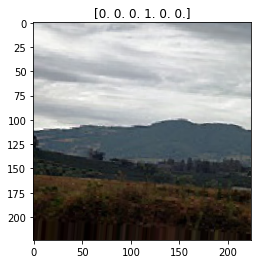

In [ ]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

# Transfer learning

https://keras.io/api/applications/

**ResNet50**


very deep neural network with 50 layers (convolutional + fully connected layer)

1. **Residual Connection**: Instead of passing the input directly to the next layer, it is passed through a "shortcut" or "skip connection" and added to the output of the subsequent layers. -> allows direct flow of information through the network, even in very deep architectures, which helps to alleviate the vanishing gradient problem.

2. **Global Average Pooling**



In [ ]:
# Step 1: Load and Preprocess the Dataset (train_gen)
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

# Step 2: Load the Pre-Trained Model (Inception_V3 in this case)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

# Step 3: Add Custom Layers
x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# Training model

`ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)`

Save the model with the highest `val_acc`(using save_best_only)as a file named model.h5

https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
# This callback allows you to save the model during training.
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
439/439 [==============================] - 220s 475ms/step - loss: 2.3135 - acc: 0.6667 - val_loss: 1.8265 - val_acc: 0.2363

Epoch 00001: val_acc improved from -inf to 0.23633, saving model to model.h5
Epoch 2/20
439/439 [==============================] - 210s 477ms/step - loss: 0.4927 - acc: 0.8317 - val_loss: 0.6903 - val_acc: 0.7467

Epoch 00002: val_acc improved from 0.23633 to 0.74667, saving model to model.h5
Epoch 3/20
439/439 [==============================] - 210s 478ms/step - loss: 0.4574 - acc: 0.8453 - val_loss: 0.6999 - val_acc: 0.7437

Epoch 00003: val_acc did not improve from 0.74667
Epoch 4/20
439/439 [==============================] - 210s 478ms/step - loss: 0.5065 - acc: 0.8180 - val_loss: 0.5007 - val_acc: 0.8407

Epoch 00004: val_acc improved from 0.74667 to 0.84067, saving model to model.h5
Epoch 5/20
439/439 [==============================] - 211s 480ms/step - loss: 0.4068 - acc: 0.8598 - val_loss: 0.7825 - val_acc: 0.7263

Epoch 00005: val_acc did not

# Training Result Graph

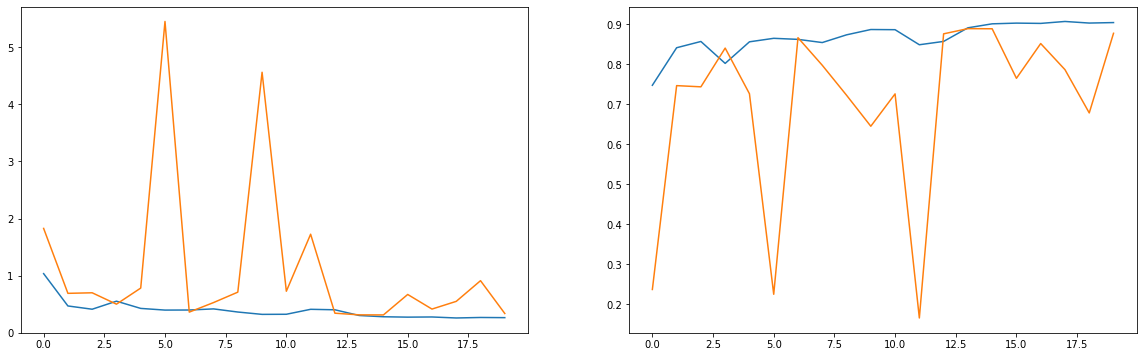

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# Loading a trained machine

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


# Test on the trained machine

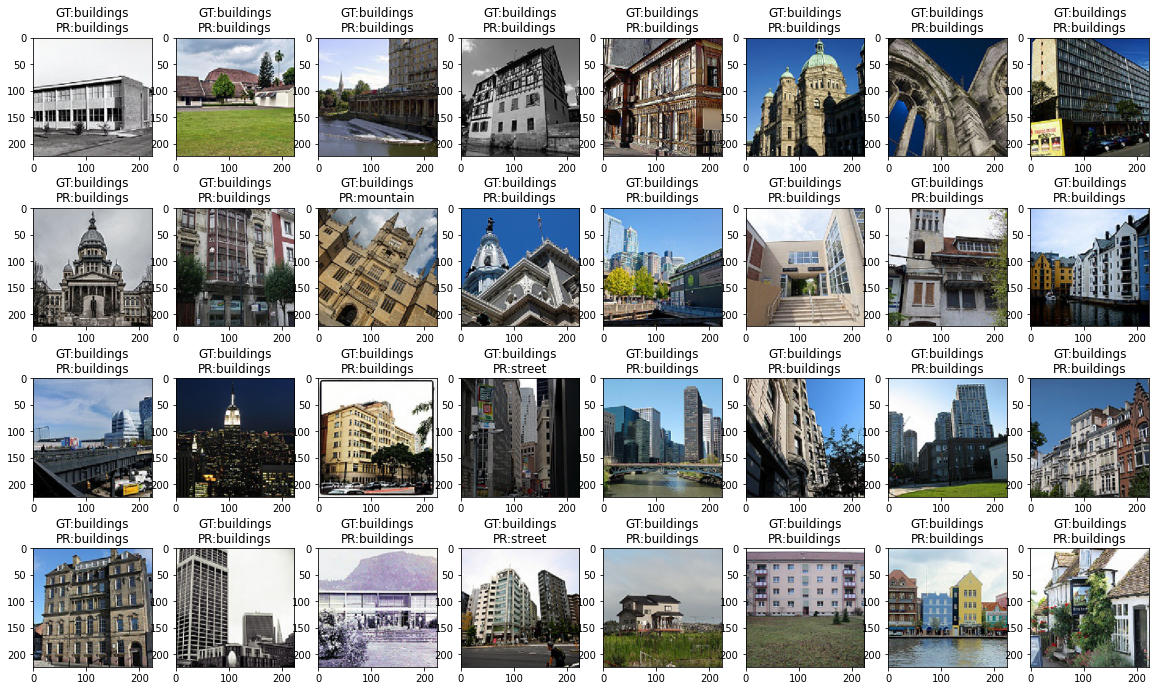

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(1)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)